# OpenAI, Consumer based sentiment Analysis

-- To Be Written --

## Data Collection

In [ ]:
import os
import asyncio
import pandas as pd
import json
import datetime
from asyncpraw import Reddit
from asyncpraw.models import MoreComments

# Load Reddit API credentials from environment variables
USERNAME = os.getenv('USER')
if not USERNAME:
    raise ValueError("USER environment variable not set")

PASSWORD = os.getenv('PASSWORD')
if not PASSWORD:
    raise ValueError("PASSWORD environment variable not set")

CLIENT_ID = os.getenv('CLIENT_ID')
if not CLIENT_ID:
    raise ValueError("CLIENT_ID environment variable not set")

CLIENT_SECRET = os.getenv('CLIENT_SECRET')
if not CLIENT_SECRET:
    raise ValueError("CLIENT_SECRET environment variable not set")


async def create_reddit_instance():
    reddit = Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent="my user agent",
        username=USERNAME,
        password=PASSWORD,
    )
    
    # Enable rate limit handling
    reddit.requestor.rate_limit_sleep = True  # Auto-handles rate-limiting
    return reddit


def load_csv_data(file_path):
    """
    Reads the CSV file and groups the queries by post_id.
    Ensures that all query values are strings before joining.
    Returns a dictionary mapping post_id -> query string.
    """
    df = pd.read_csv(file_path)

    # Convert queries to strings and handle NaN values
    df["query"] = df["query"].fillna("").astype(str)

    # Group by post_id and join unique queries with a semicolon.
    grouped = df.groupby("post_id")["query"].apply(lambda x: ";".join(set(x))).reset_index()
    mapping = dict(zip(grouped["post_id"], grouped["query"]))

    return mapping


async def fetch_post_and_comments(reddit, post_id):
    """
    Fetches the submission and its top 10 first-level comments.
    Returns a list of dictionaries containing post and comment details.
    In case of an error, returns one dictionary with error details.
    """
    rows = []
    try:
        submission = await reddit.submission(id=post_id)  # Await here
        
        # Load submission details
        await submission.load()
        
        # Fetch top-level comments (limit: 10)
        await submission.comments.replace_more(limit=10)
        top_comments = submission.comments[:10]

        submission_details = {
            "post_id": submission.id,
            "subreddit": submission.subreddit.display_name,
            "post_title": submission.title,
            "post_body": submission.selftext,
            "number_of_comments": submission.num_comments,
            "readable_datetime": datetime.datetime.fromtimestamp(submission.created_utc).strftime("%Y-%m-%d %H:%M:%S"),
            "post_author": submission.author.name if submission.author else None,
        }

        if top_comments:
            for comment in top_comments:
                if isinstance(comment, MoreComments):  # Skip "load more" placeholders
                    continue
                row = submission_details.copy()
                row.update({
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "number_of_upvotes": comment.score,
                    "comment_author": comment.author.name if comment.author else None,
                })
                rows.append(row)
        else:
            # No comments found; create a row with only post details
            row = submission_details.copy()
            row.update({
                "comment_id": None,
                "comment_body": None,
                "number_of_upvotes": None,
                "comment_author": None,
            })
            rows.append(row)

    except Exception as e:
        print(f"Error fetching data for post_id {post_id}: {e}")
        # Return an error row where key details (like 'subreddit') are None.
        rows.append({
            "post_id": post_id,
            "subreddit": None,
            "post_title": None,
            "post_body": None,
            "number_of_comments": None,
            "readable_datetime": None,
            "post_author": None,
            "comment_id": None,
            "comment_body": None,
            "number_of_upvotes": None,
            "comment_author": None,
        })
    
    return rows


def save_csv(data, file_name):
    """Writes the provided data (a list of dictionaries) to a CSV file."""
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False)
    print(f"CSV file saved as {file_name}")


def save_json(data, file_name):
    """Writes the provided data (a list of dictionaries) to a JSON file."""
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"JSON file saved as {file_name}")


async def countdown(seconds):
    """Displays a countdown timer for the given number of seconds."""
    for remaining in range(seconds, 0, -1):
        print(f"Resuming in {remaining:2d} seconds...", end="\r", flush=True)
        await asyncio.sleep(1)
    print("")  # Move to a new line after countdown


async def main():
    reddit = await create_reddit_instance()
    post_query_mapping = load_csv_data("combined_data.csv")
    all_post_ids = list(post_query_mapping.keys())
    
    # Check for an existing checkpoint (processed post_ids)
    checkpoint_file = "checkpoint.json"
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "r", encoding="utf-8") as f:
            processed_ids = json.load(f)
        print(f"Resuming from checkpoint: {len(processed_ids)} posts already processed.")
    else:
        processed_ids = []

    # Only process posts that have not yet been processed.
    to_process_all = [post_id for post_id in all_post_ids if post_id not in processed_ids]
    print(f"Total posts to process: {len(to_process_all)}")

    # Maintain a retry counter for each post.
    retries = {post_id: 0 for post_id in to_process_all}
    max_retries = 3  # Maximum attempts per post
    batch_size = 30  # Number of posts to process per mini-batch

    # Define output file names.
    output_csv = "raw_dataset.csv"
    output_json = "raw_dataset.json"

    # If output files already exist, load their data; otherwise, start with an empty list.
    if os.path.exists(output_csv):
        existing_df = pd.read_csv(output_csv)
        output_data = existing_df.to_dict(orient="records")
    else:
        output_data = []

    while to_process_all:
        print(f"\nStarting a round with {len(to_process_all)} posts to process.")
        next_to_process = []  # To hold posts that need to be retried

        # Process posts in mini-batches.
        for i in range(0, len(to_process_all), batch_size):
            batch_ids = to_process_all[i:i+batch_size]
            print(f"\nProcessing mini-batch {i // batch_size + 1} "
                  f"of {((len(to_process_all)-1) // batch_size) + 1} (posts: {batch_ids})")
            
            tasks = [fetch_post_and_comments(reddit, post_id) for post_id in batch_ids]
            results = await asyncio.gather(*tasks)
            
            for post_id, rows in zip(batch_ids, results):
                # If the first row's "subreddit" is None, we assume an error occurred.
                if rows and rows[0]["subreddit"] is None:
                    retries[post_id] += 1
                    if retries[post_id] < max_retries:
                        print(f"Error for post_id {post_id}; retrying (attempt {retries[post_id]}/{max_retries}).")
                        next_to_process.append(post_id)
                    else:
                        print(f"Error for post_id {post_id} after {max_retries} attempts; logging error.")
                        for row in rows:
                            row["query"] = post_query_mapping.get(post_id, "")
                        output_data.extend(rows)
                        processed_ids.append(post_id)
                else:
                    # Successful result.
                    for row in rows:
                        row["query"] = post_query_mapping.get(post_id, "")
                    output_data.extend(rows)
                    processed_ids.append(post_id)
            
            # Incrementally save output after each mini-batch.
            save_csv(output_data, output_csv)
            save_json(output_data, output_json)
            # Update the checkpoint.
            with open(checkpoint_file, "w", encoding="utf-8") as f:
                json.dump(processed_ids, f, indent=4)
            
            print("Mini-batch processed. Waiting 60 seconds before the next mini-batch...")
            await countdown(60)

        if next_to_process:
            print(f"\nRetrying {len(next_to_process)} posts in the next round...\n")
            to_process_all = next_to_process
        else:
            break

    print("All posts processed.")

In [4]:
import nest_asyncio
nest_asyncio.apply()

async def run_async():
    await main()

await run_async()

C:\Users\User\AppData\Local\Temp\ipykernel_34020\1641351664.py:47: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Total posts to process: 9575

Starting a round with 9575 posts to process.

Processing mini-batch 1 of 320 (posts: [' the next era is the niche content producer who produces high quality video content', '1002dom', '1007cpq', '100ayoe', '100ye6s', '101chgd', '101melg', '101ms83', '101o6zx', '101p00n', '102ci8x', '102jcse', '102l28b', '102lbp8', '102lrwi', '102xqim', '1030pti', '1030xji', '1031mz4', '1031yi2', '10346f5', '1035gzm', '103ahhi', '103gran', '103qc9j', '103vj6v', '103w7m4', '103wsie', '103yg7r', '1041tuw'])
Error fetching data for post_id  the next era is the niche content producer who produces high quality video content: received 404 HTTP response
Error fetching data for post_id 1030xji: received 429 HTTP response
Error for post_id  the next era is the niche content producer who produces high quality video content; retrying (attempt 1/3).
Error for post_id 1030xji; retrying (attempt 1/3).
CSV file saved as new_combined_dataset.csv
JSON file saved as new_combined_dataset.json

### Raw-Data Visualization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [5]:
# Load dataset
file_path = "Data/raw_dataset.csv"
df = pd.read_csv(file_path)

#### Basic Information

In [6]:
# Display basic information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54966 entries, 0 to 54965
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   post_id             54966 non-null  object 
 1   subreddit           54954 non-null  object 
 2   post_title          54954 non-null  object 
 3   post_body           30349 non-null  object 
 4   number_of_comments  54954 non-null  float64
 5   readable_datetime   54954 non-null  object 
 6   post_author         54478 non-null  object 
 7   comment_id          54352 non-null  object 
 8   comment_body        54350 non-null  object 
 9   number_of_upvotes   54352 non-null  float64
 10  comment_author      49478 non-null  object 
 11  query               52113 non-null  object 
dtypes: float64(2), object(10)
memory usage: 5.0+ MB


In [7]:
# Sample records
print("\nSample Records:")
display(df.head())


Sample Records:


,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,comment_id,comment_body,number_of_upvotes,comment_author,query
0,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2far1e,Chat GPT wrote this article ffs,792.0,The_Bridge_Imperium,ChatGPT
1,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f5vg2,Did you order the code red?,687.0,damienn22,ChatGPT
2,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f9y5m,If my search engine was littered with SEO keyw...,1288.0,1x2x4x1,ChatGPT
3,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f7njc,How many more times are we gonna see this story,306.0,frombaktk,ChatGPT
4,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2fna2c,How far can we trust ChatGPT? It's very intere...,70.0,Milk_Busters,ChatGPT


In [8]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
post_id                   0
subreddit                12
post_title               12
post_body             24617
number_of_comments       12
readable_datetime        12
post_author             488
comment_id              614
comment_body            616
number_of_upvotes       614
comment_author         5488
query                  2853
dtype: int64


In [10]:
# Basic statistics
df["post_title_length"] = df["post_title"].astype(str).apply(len)
df["post_body_length"] = df["post_body"].astype(str).apply(len)
df["comment_body_length"] = df["comment_body"].astype(str).apply(len)

# Unique vs. Duplicate text
unique_titles = df["post_title"].nunique()
unique_bodies = df["post_body"].nunique()
unique_comments = df["comment_body"].nunique()

print("\nUnique vs Duplicate Counts:")
print(f"Unique Post Titles: {unique_titles}/{len(df)}")
print(f"Unique Post Bodies: {unique_bodies}/{len(df)}")
print(f"Unique Comments: {unique_comments}/{len(df)}")



Unique vs Duplicate Counts:
Unique Post Titles: 9426/54966
Unique Post Bodies: 5793/54966
Unique Comments: 51594/54966


#### Charecter Length

In [ ]:
# Summary statistics for text lengths = BASED ON CHARECTERS
text_length_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Length": [
        df["post_title_length"].min(),
        df["post_title_length"].quantile(0.25),
        df["post_title_length"].median(),
        df["post_title_length"].quantile(0.75),
        df["post_title_length"].max(),
        df["post_title_length"].mean(),
    ],
    "Post Body Length": [
        df["post_body_length"].min(),
        df["post_body_length"].quantile(0.25),
        df["post_body_length"].median(),
        df["post_body_length"].quantile(0.75),
        df["post_body_length"].max(),
        df["post_body_length"].mean(),
    ],
    "Comment Body Length": [
        df["comment_body_length"].min(),
        df["comment_body_length"].quantile(0.25),
        df["comment_body_length"].median(),
        df["comment_body_length"].quantile(0.75),
        df["comment_body_length"].max(),
        df["comment_body_length"].mean(),
    ],
})

# Display the table in a Jupyter Notebook-friendly format
from IPython.display import display
display(text_length_stats)


,Metric,Post Title Length,Post Body Length,Comment Body Length
0,Min,1.000000,1.000000,1.000000
1,25th Percentile,41.000000,3.000000,51.000000
2,Median (50th),63.000000,100.000000,118.000000
3,75th Percentile,94.000000,676.000000,274.000000
4,Max,300.000000,36834.000000,9996.000000
5,Mean,76.353036,745.767129,240.651002


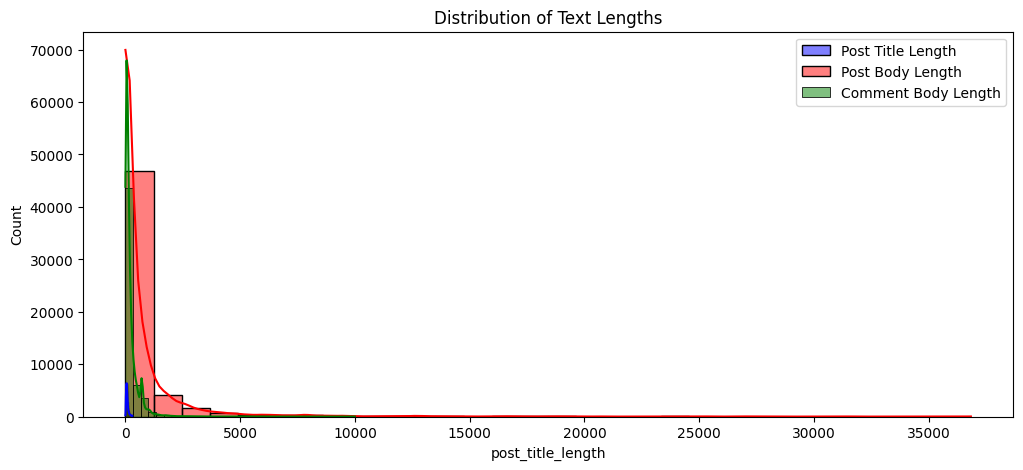

In [11]:
# Plot distribution of text lengths
plt.figure(figsize=(12, 5))
sns.histplot(df["post_title_length"], bins=30, kde=True, color='blue', label="Post Title Length")
sns.histplot(df["post_body_length"], bins=30, kde=True, color='red', label="Post Body Length")
sns.histplot(df["comment_body_length"], bins=30, kde=True, color='green', label="Comment Body Length")
plt.legend()
plt.title("Distribution of Text Lengths")
plt.show()

#### Word Length

In [22]:
df["post_title_word_count"] = df["post_title"].astype(str).apply(lambda x: len(x.split()))
df["post_body_word_count"] = df["post_body"].astype(str).apply(lambda x: len(x.split()))
df["comment_body_word_count"] = df["comment_body"].astype(str).apply(lambda x: len(x.split()))

# Summary statistics for word counts
word_count_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Word Count": [
        df["post_title_word_count"].min(),
        df["post_title_word_count"].quantile(0.25),
        df["post_title_word_count"].median(),
        df["post_title_word_count"].quantile(0.75),
        df["post_title_word_count"].max(),
        df["post_title_word_count"].mean(),
    ],
    "Post Body Word Count": [
        df["post_body_word_count"].min(),
        df["post_body_word_count"].quantile(0.25),
        df["post_body_word_count"].median(),
        df["post_body_word_count"].quantile(0.75),
        df["post_body_word_count"].max(),
        df["post_body_word_count"].mean(),
    ],
    "Comment Body Word Count": [
        df["comment_body_word_count"].min(),
        df["comment_body_word_count"].quantile(0.25),
        df["comment_body_word_count"].median(),
        df["comment_body_word_count"].quantile(0.75),
        df["comment_body_word_count"].max(),
        df["comment_body_word_count"].mean(),
    ],
})

# Display the table
display(word_count_stats)

,Metric,Post Title Word Count,Post Body Word Count,Comment Body Word Count
0,Min,1.000000,0.000000,1.00000
1,25th Percentile,7.000000,1.000000,9.00000
2,Median (50th),11.000000,12.000000,20.00000
3,75th Percentile,16.000000,109.000000,47.00000
4,Max,58.000000,5815.000000,1815.00000
5,Mean,13.105593,117.701925,39.56393


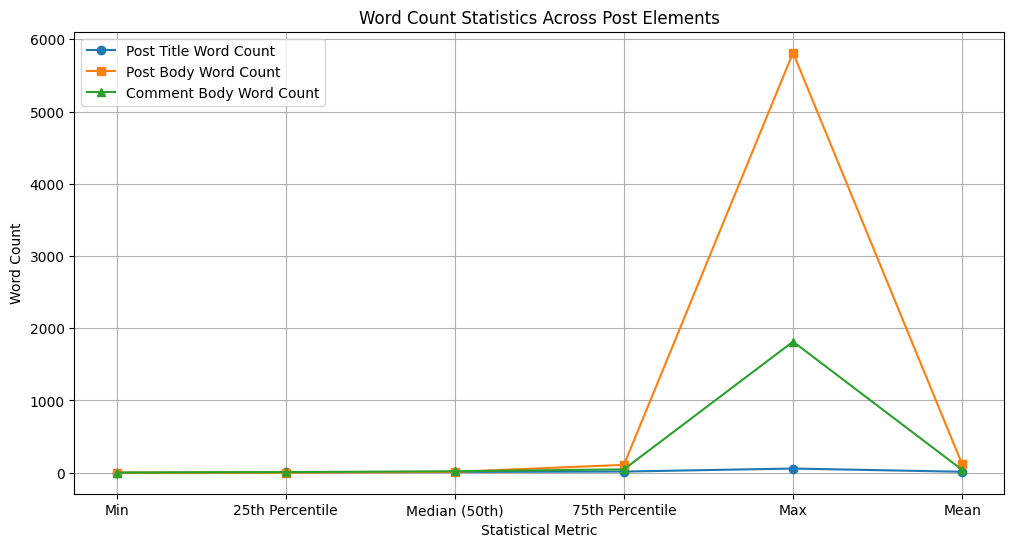

In [23]:
# Define the metrics for x-axis
metrics = ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"]
x_labels = range(len(metrics))  # X-axis positions

# Create a figure for word count statistics
plt.figure(figsize=(12, 6))

# Plot lines for each text category
plt.plot(x_labels, word_count_stats["Post Title Word Count"], marker="o", label="Post Title Word Count")
plt.plot(x_labels, word_count_stats["Post Body Word Count"], marker="s", label="Post Body Word Count")
plt.plot(x_labels, word_count_stats["Comment Body Word Count"], marker="^", label="Comment Body Word Count")

# Formatting the plot
plt.xticks(x_labels, metrics)  # Set x-axis labels
plt.ylabel("Word Count")
plt.xlabel("Statistical Metric")
plt.title("Word Count Statistics Across Post Elements")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


#### Frequency Analysis

In [14]:
# Comment frequency analysis
comment_freq = df["comment_body"].value_counts().head(20)
print("\nTop 20 Most Frequent Comments:")
display(comment_freq)


Top 20 Most Frequent Comments:


comment_body
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  1298
[removed]                                                                                                                                                                                                                                                  

C:\Users\User\AppData\Local\Temp\ipykernel_27320\3579888780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comment_freq.index, y=comment_freq.values, palette="coolwarm")


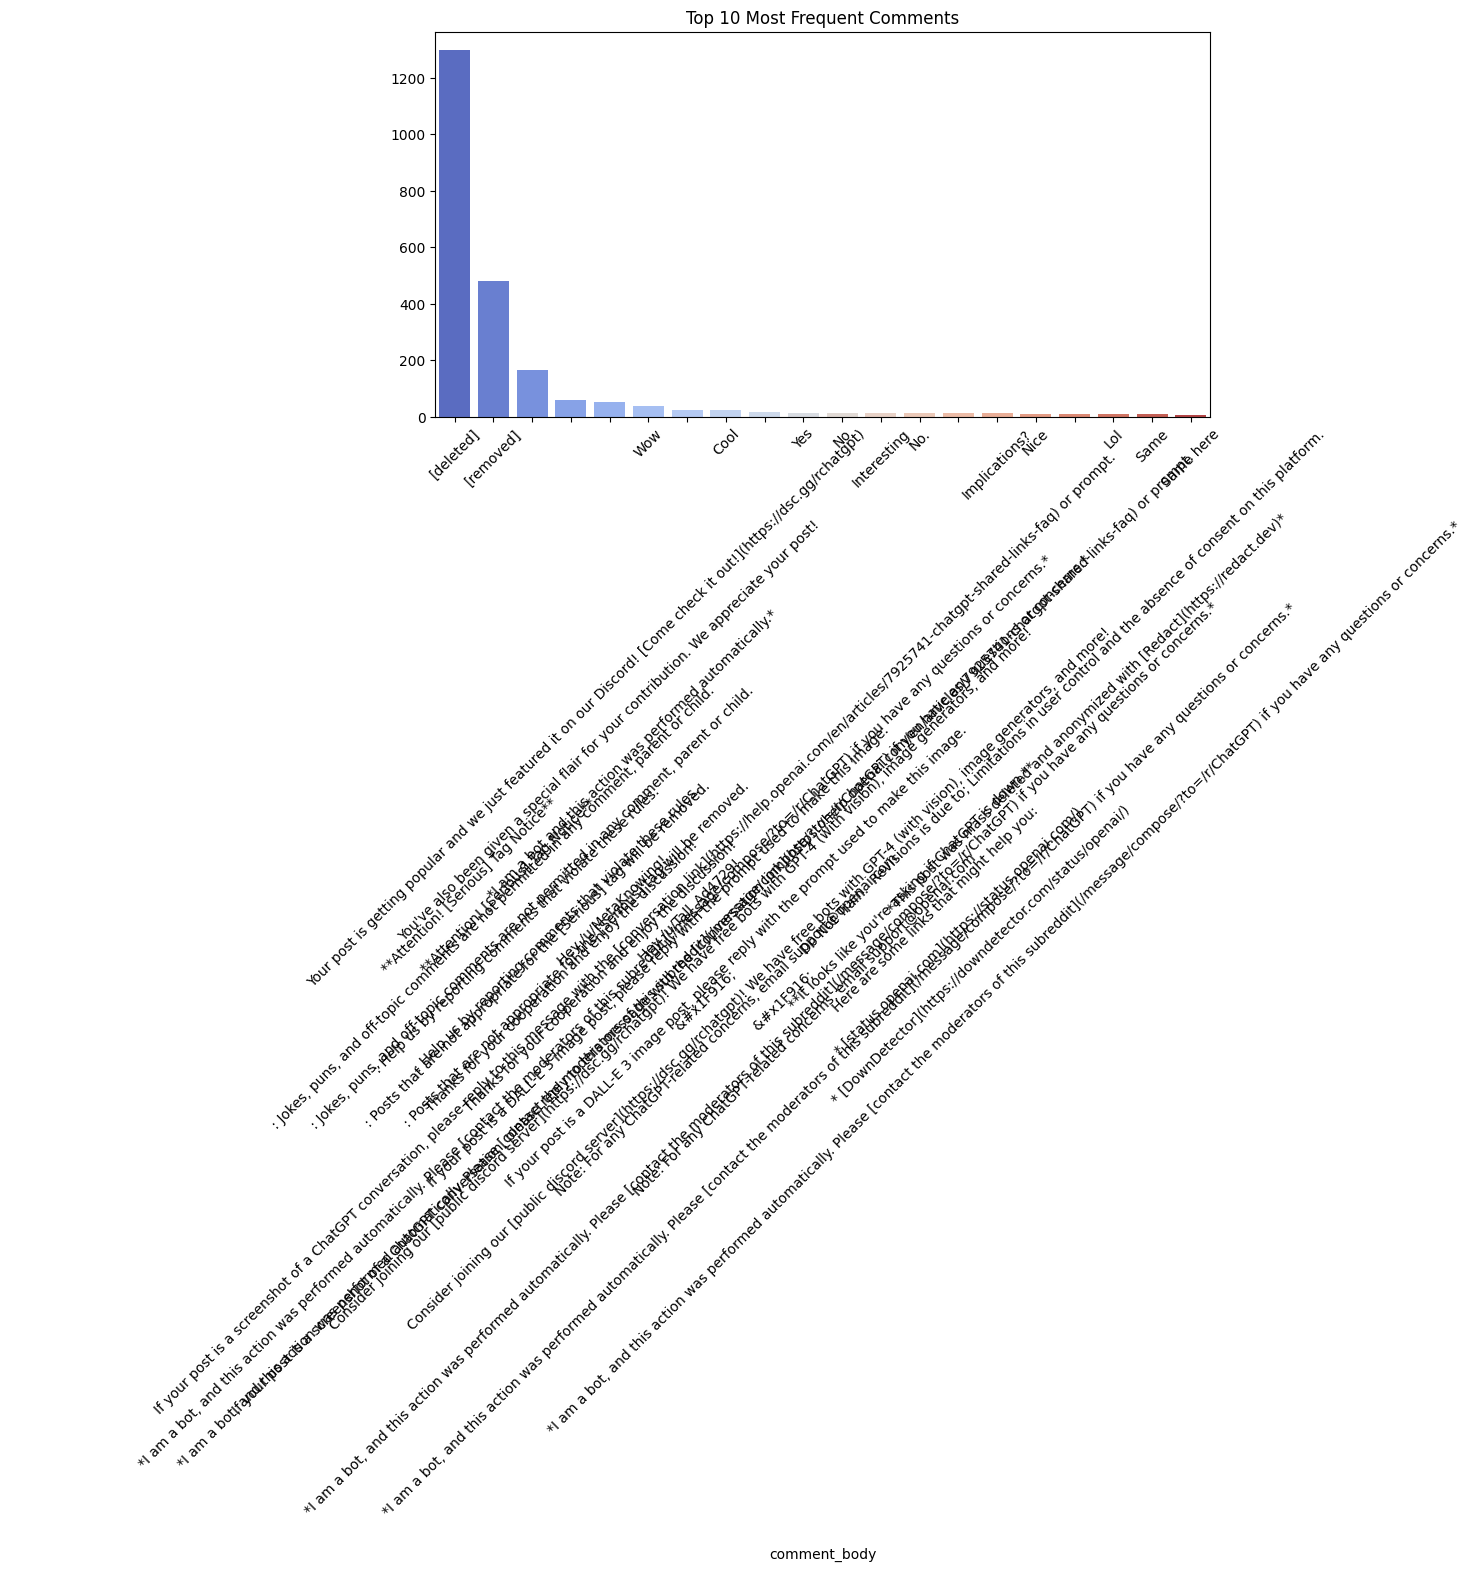

In [15]:
plt.figure(figsize=(10, 5))
sns.barplot(x=comment_freq.index, y=comment_freq.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Comments")
plt.show()

#### Sample Data

In [24]:
# Show some examples
print("\nSample Posts and Comments:")
sample_data = df[["post_title", "post_body", "comment_body"]].sample(10, random_state=42)
display(sample_data)


Sample Posts and Comments:


,post_title,post_body,comment_body
47632,AI models now outperform PhD experts in their ...,NaN,I love how he just adds 'exponential' to what ...
28105,Due to the speed of AI development and the lon...,NaN,Academic papers run the gamut from top notch i...
22395,Brad Lightcap (an OpenAI executive) just said ...,https://x.com/legit_rumors/status/178768158049...,So we're getting a great teammate in 12 months...
47673,My 100% human written paragraph was flagged as...,"Many online forms right now, oblige you not to...",This AI Detector is not commonly used. Use som...
54365,"hey guys, it says open A.I is not available in...",But my country is in the Philippines but I cur...,"If you have access to the app telegram, there'..."
10151,Is it me or does Dall-E 3 not produce realisti...,NaN,It’s amazing to be honest
54660,ChatGPT PRO app in the Play Store: Is this legit?,NaN,This doesn't look like something done by OpenA...
3184,OpenAI will discontinue support for their Code...,NaN,Cool - now I can close the tab I had open in m...
19962,GPT-3.5-turbo doesn't complete task,I'm experimenting with API calls to `GPT-3.5-t...,GPT 3.5 has reached its full teenage potential…
1566,Sydney (Bing GPT) is scarily similar to Samant...,\n\nWhen New Bing was announced on the 7th of...,We need waifuGPT


# Data Cleaning

In [ ]:
data = pd.read_csv('raw_dataset.csv')

print("Number of posts:",len(data['post_id'].unique()))
print("Posts without comments:", len(data[data['comment_id'].isna()]))



# Ensure that the post_id is 7 characters long
data = data[data['post_id'].str.len() == 7]

#Remove all records where subreddit is null
data = data[data['subreddit'].notnull()]


data['post_title'] = data['post_title'].str.replace('\n', ' ')
data['post_body'] = data['post_body'].str.replace('\n', ' ')
data['comment_body'] = data['comment_body'].str.replace('\n', ' ')

# Reencode the data to utf-8
data['post_title'] = data['post_title'].str.encode('utf-8', 'ignore').str.decode('utf-8')
data['post_body'] = data['post_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')
data['comment_body'] = data['comment_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')

data['number_of_upvotes'] = data['number_of_upvotes'].fillna(0)

# Remove where comment_body is [deleted] or [removed]
data = data[data['comment_body'] != '[deleted]']
data = data[data['comment_body'] != '[removed]']

# Remove comment body when count is greater than 50
# Keep records where comment_body is null or appears <= 50 times
# Create a mask for records where comment_body is null or appears <= 50 times
comment_counts = data['comment_body'].value_counts()
mask = (data['comment_body'].isna()) | (data['comment_body'].map(lambda x: comment_counts.get(x, 0) <= 50))
data = data[mask]

# Remove data that matches the regex pattern, handling NaN values
data = data[~data['comment_body'].fillna('').str.contains(r'^Hey\s+/u/\w+.*?$', regex=True)]
data = data[~data['comment_body'].fillna('').str.contains(r'^.*?if you have any questions or concerns.*?$', regex=True)]
data = data[~data['comment_body'].fillna('').str.contains(r'\[ Removed by Reddit \]', regex=True)]
data = data[~data['comment_body'].fillna('').str.contains(r'^.*?\[.*?\].*?$', regex=True)]

# Store the data in a new CSV file
data.to_csv('cleaned_data.csv', index=False)


# Check number post (has post_id but no comment_id)
print("\nAfter cleaning the data")
print("Number of posts:",len(data['post_id'].unique()))
print("Posts without comments:", len(data[data['comment_id'].isna()]))


## Data Preprocessing

In [ ]:
raw_data = pd.read_csv('cleaned_data.csv', 
					   engine='pyarrow',     # Use python engine instead of pyarrow
					   encoding='utf-8',    # Specify encoding
)

# Declare each field data type
raw_data['post_id'] = raw_data['post_id'].astype(str)
raw_data['comment_id'] = raw_data['comment_id'].astype(str)
raw_data['post_title'] = raw_data['post_title'].astype(str)
raw_data['post_body'] = raw_data['post_body'].astype(str)
raw_data['post_author'] = raw_data['post_author'].astype(str)
raw_data['comment_body'] = raw_data['comment_body'].astype(str)
raw_data['comment_author'] = raw_data['comment_author'].astype(str)
raw_data['query'] = raw_data['query'].astype(str)

raw_data['subreddit'] = raw_data['subreddit'].astype('category')
raw_data['query'] = raw_data['query'].astype('category')

# Fill NaN values with 0 before converting to int
raw_data['number_of_comments'] = raw_data['number_of_comments'].fillna(0).astype(int)
raw_data['number_of_upvotes'] = raw_data['number_of_upvotes'].fillna(0).astype(int)

raw_data['readable_datetime'] = pd.to_datetime(raw_data['readable_datetime'])

print(raw_data.head())

In [ ]:
# Create combined text field and replace None/NaN with empty string
raw_data["text"] = raw_data.apply(
	lambda row: (
		str(row['comment_body']).strip() if pd.notna(row['comment_body'])
		else ""), 
	axis=1
).fillna("")

# Print count
print("Number of empty texts:", (raw_data["text"] == "").sum())
print("Number of NA texts:", raw_data["text"].isna().sum())
print("Total records:", len(raw_data))

# Drop rows where text is empty
raw_data = raw_data[raw_data["text"] != ""]

# Add a new row for all unique posts (get post_id, comments, and all from first record of the post, exclude any comment fields)
posts = raw_data.groupby("post_id").first().reset_index()
posts = posts.drop(columns=["comment_id", "comment_body", "comment_author","text"])

print("\nNumber of posts:", len(posts))

# Make post text the as post title and post body
posts["text"] = posts["post_title"] + " " + posts["post_body"]

# concat raw data and posts
raw_data = pd.concat([posts, raw_data], ignore_index=True)

# Remove any duplicate rows
raw_data = raw_data.drop_duplicates()

# Display first few rows and value counts of empty strings
print("\n After adding new row for all unique posts")
print("\nNumber of empty texts:", (raw_data["text"] == "").sum())
print("Number of NA texts:", raw_data["text"].isna().sum())
print("Total records:", len(raw_data))

In [ ]:
# No.of Posts and Comments
print("\nNumber of Posts and Comments:")
print(raw_data["post_id"].nunique())
print(raw_data["comment_id"].count())

In [ ]:
filtered_data = raw_data.copy()

###  S1: Filter to past 5 year

In [ ]:
from datetime import datetime, timedelta

In [ ]:
cutoff_date = datetime.now() - timedelta(days=5*365)

filtered_data = filtered_data[filtered_data["readable_datetime"] > cutoff_date]

print("\nNumber of Posts and Comments after filtering:")
print(filtered_data["post_id"].nunique())
print(filtered_data["comment_id"].count())

# Print date time range in the data
print("\nDate time range:")
print(filtered_data["readable_datetime"].min())
print(filtered_data["readable_datetime"].max())

In [ ]:
# Remove all missing records where text is empty
filtered_data = filtered_data[filtered_data["text"] != ""]
filtered_data = filtered_data[filtered_data["text"].notna()]
filtered_data = filtered_data[filtered_data["text"] != "nan"]
filtered_data = filtered_data[filtered_data["text"] != "None"]

### S2: Text Length

Short Texts: Extremely short texts (e.g., those with only one or two words) might not provide enough context and could be noise.

Excessively Long Texts: Conversely, texts that far exceed the typical length for your domain might be off-topic or contain noise.

In [ ]:
from tabulate import tabulate


min_words = 3

# Calculate word counts for each text
word_counts = filtered_data['text'].str.split().str.len()

print("\nWord count statistics:")
print(tabulate([word_counts.describe()], headers='keys'))
print("\n")


# Set max_words as the upper quartile (75th percentile) plus 1.5 times IQR
Q3 = word_counts.quantile(0.75)
Q1 = word_counts.quantile(0.25)
IQR = Q3 - Q1
max_words = int(Q3 + 1.5 * IQR)

print(f"Max words set to: {max_words}")

In [ ]:
print(filtered_data["post_id"].nunique())
print(filtered_data["comment_id"].isna().sum())

# First recalculate word counts since filtered_data has been modified since last count
word_counts = filtered_data['text'].str.split().str.len()

# Filter based on min and max words
filtered_data = filtered_data[word_counts.between(min_words, max_words)]

print("\nNumber of Posts and Comments after filtering by word count:")
print(filtered_data["post_id"].nunique())
print(filtered_data["comment_id"].isna().sum())

In [ ]:
# Store the filtered data in a new CSV file
filtered_data.to_csv('filtered_data.csv', index=False)

## Tf-idf Vector

In [ ]:
# Todo

## Embedding

In [ ]:
# Todo

## Labeling

In [ ]:
# Todo

## Pipeline (Part - C)